---
# Getting Started with AmpliGraph
---
In this tutorial we will demonstrate how to use the AmpliGraph library. 

Things we will cover:

1. Exploration of a graph dataset
2. Splitting graph datasets into train and test sets
3. Training a model
4. Model selection and hyper-parameter search 
5. Saving and restoring a model
6. Evaluating a model
7. Using link prediction to discover unknown relations
8. Visualizing embeddings using Tensorboard

---

## Requirements

A Python environment with the AmpliGraph library installed. Please follow [the install guide](http://docs.ampligraph.org/en/latest/install.html).



Some sanity check:

In [1]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

tf.__version__

'1.13.1'

## 1. Dataset exploration

First things first! Lets import the required libraries and retrieve some data.

In this tutorial we're going to use the [**Game of Thrones knowledge Graph**](https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv). Please note: this isn't the *greatest* dataset for demonstrating the power of knowledge graph embeddings, but is small, intuitive and should be familiar to most users. 

We downloaded the [neo4j graph published here](https://github.com/neo4j-examples/game-of-thrones). Such dataset has been generated using [these APIs](https://anapioficeandfire.com/)  which expose in a machine-readable fashion the content of open free sources such as A [Wiki of Ice and Fire](http://awoiaf.westeros.org/). We discarded all properties and saved all the directed, labeled relations in a plaintext file. Each relation (i.e. a triple) is in the form: 

    <subject, predicate, object>

The schema of the graph looks like this (image from [neo4j-examples/game-of-thrones](https://github.com/neo4j-examples/game-of-thrones)):

![](img/got-graphql-schema.jpg)

Run the following cell to pull down the dataset and load it in memory with AmpliGraph [`load_from_csv()`](http://docs.ampligraph.org/en/1.0.3/generated/ampligraph.datasets.load_from_csv.html#ampligraph.datasets.load_from_csv) utility function:

In [2]:
import requests
from ampligraph.datasets import load_from_csv

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
open('GoT.csv', 'wb').write(requests.get(url).content)
X = load_from_csv('.', 'GoT.csv', sep=',')
X[:5, ]

array([['Smithyton', 'SEAT_OF', 'House Shermer of Smithyton'],
       ['House Mormont of Bear Island', 'LED_BY', 'Maege Mormont'],
       ['Margaery Tyrell', 'SPOUSE', 'Joffrey Baratheon'],
       ['Maron Nymeros Martell', 'ALLIED_WITH',
        'House Nymeros Martell of Sunspear'],
       ['House Gargalen of Salt Shore', 'IN_REGION', 'Dorne']],
      dtype=object)

Let's list the subject and object entities found in the dataset:

In [3]:
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
entities

array(['Abelar Hightower', 'Acorn Hall', 'Addam Frey', ..., 'the Antlers',
       'the Paps', 'unnamed tower'], dtype=object)

.. and all of the relationships that link them. Remember, these relationships only link *some* of the entities.

In [4]:
relations = np.unique(X[:, 1])
relations

array(['ALLIED_WITH', 'BRANCH_OF', 'FOUNDED_BY', 'HEIR_TO', 'IN_REGION',
       'LED_BY', 'PARENT_OF', 'SEAT_OF', 'SPOUSE', 'SWORN_TO'],
      dtype=object)

# 2. Defining train and test datasets

As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets. 

What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple. 

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.  

For sake of example, we will create a small test size that includes only 100 triples:

In [5]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=100) 

Our data is now split into train/test sets. If we need to further divide into a validation dataset we can just repeat using the same procedure on the test set (and adjusting the split percentages). 

In [6]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (3075, 3)
Test set size:  (100, 3)


---
# 3. Training a model 

AmpliGraph has implemented [several Knoweldge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model (with  default values), so lets import that:

In [7]:
from ampligraph.latent_features import ComplEx

Lets go through the parameters to understand what's going on:

- **`k`** : the dimensionality of the embedding space
- **`eta`** ($\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple
- **`batches_count`** : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- **`epochs`** : the number of epochs to train the model for.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-3 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=2$, i.e. l2 regularization. $\lambda$ = 1e-5, set via the *regularizer_params* kwarg. 

Now we can instantiate the model:


In [8]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

## Filtering negatives

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions. 

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no *negative* statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.  


In [9]:
positives_filter = X

## Fitting the model

Once you run the next cell the model will train. 

On a modern laptop this should take ~3 minutes (although your mileage may vary, especially if you've changed any of the hyper-parameters above).

In [10]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average Loss:   0.033250: 100%|███████████████████████████████████████████████████| 200/200 [03:53<00:00,  1.17s/epoch]


---
# 5.  Saving and restoring a model

Before we go any further, let's save the best model found so that we can restore it in future.

In [11]:
from ampligraph.latent_features import save_model, restore_model

In [12]:
save_model(model, './best_model.pkl')

This will save the model in the ampligraph_tutorial directory as `best_model.pkl`.

.. we can then delete the model .. 

In [13]:
del model

.. and then restore it from disk! Ta-da! 

In [14]:
model = restore_model('./best_model.pkl')

And let's just double check that the model we restored has been fit:

In [15]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


---
# 6. Evaluating a model

Now it's time to evaluate our model on the test set to see how well it's performing. 

For this we'll use the `evaluate_performance` function:

In [16]:
from ampligraph.evaluation import evaluate_performance

And let's look at the arguments to this function:

- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.


## Running evaluation

In [17]:
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.48it/s]



The ***ranks*** returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model. 

For example, given the triple:

    <House Stark of Winterfell, IN_REGION The North>
    
The model returns a rank of 7. This tells us that while it's not the highest likelihood true statement (which would be given a rank 1), it's pretty likely.


## Metrics

Let's compute some evaluate metrics and print them out.

We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions. 

- ***mrr_score***:  The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- ***hits_at_n_score***: The function computes how many elements of a vector of rankings ranks make it to the top n positions.


In [18]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.46
Hits@10: 0.58
Hits@3: 0.53
Hits@1: 0.38


Now, how do we interpret those numbers? 

[Hits@N](http://docs.ampligraph.org/en/1.0.3/generated/ampligraph.evaluation.hits_at_n_score.html#ampligraph.evaluation.hits_at_n_score) indicates how many times in average a true triple was ranked in the top-N. Therefore, on average, we guessed the correct subject or object 53% of the time when considering the top-3 better ranked triples. The choice of which N makes more sense depends on the application.

The [Mean Reciprocal Rank (MRR)](http://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.mrr_score.html) is another popular metrics to assess the predictive power of a model.


# 7. Predicting New Links

Link prediction allows us to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste. 

In our case, we're going to see which of the following candidate statements (that we made up) are more likely to be true:


In [19]:
X_unseen = np.array([
    ['Daenerys Targaryen', 'SPOUSE', 'Missandei'],
    ['Grey Worm', 'SPOUSE', 'Missandei'],
    ['Arya Stark', 'SPOUSE', 'Jon Snow']
])

XX_unseen = np.array([
    ['Daenerys Targaryen', 'SPOUSE', 'Rhaegar Targaryen'],
    ['Tyrion Lannister', 'SPOUSE', 'Missandei'],
    ["King's Landing", 'SEAT_OF', 'House Lannister of Casterly Rock'],
    ['Sansa Stark', 'SPOUSE', 'Petyr Baelish'],
    ['Daenerys Targaryen', 'SPOUSE', 'Jon Snow'],
    ['Daenerys Targaryen', 'SPOUSE', 'Myrcella Baratheon'],
    ['House Stark of Winterfell', 'IN_REGION', 'The North'],
    ['House Stark of Winterfell', 'IN_REGION', 'Dorne'],
    ['House Tyrell of Highgarden', 'IN_REGION', 'Beyond the Wall'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],    
    ['Rhaegar Targaryen', 'PARENT_OF', 'Jon Snow'],
    ['House Hutcheson', 'SWORN_TO', 'House Tyrell of Highgarden'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Jaime Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Robert I Baratheon', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Brandon Stark'],
    ["Tywin Lannister", 'PARENT_OF', 'Jaime Lannister'],
    ["Missandei", 'SPOUSE', 'Grey Worm'],
    ["Brienne of Tarth", 'SPOUSE', 'Jaime Lannister']
])

In [20]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [21]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.90it/s]


In [22]:
scores = model.predict(X_unseen)

We transform the scores (real numbers) into probabilities (bound between 0 and 1) using the expit transform.

Note that the probabilities are not calibrated in any sense. 

Advanced note: To calibrate the probabilities, one may use a procedure such as [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) or [Isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression). The challenge is to define what is a true triple and what is a false one, as the calibration of the probability of a triple being true depends on the base rate of positives and negatives.

In [23]:
from scipy.special import expit
probs = expit(scores)

In [24]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
2,Arya Stark SPOUSE Jon Snow,111,1.728757,0.849253
1,Grey Worm SPOUSE Missandei,120,2.095975,0.890511
0,Daenerys Targaryen SPOUSE Missandei,66,3.156125,0.959149


We see that the embeddings captured some truths about Westeros. For example, **House Stark is placed in the North rather than Dorne**. It also realises **Daenerys Targaryen has no relation with Craster**, **nor Tyrion with Missandei**. It captures random trivia, as **House Hutcheson is indeed in the Reach and sworn to the Tyrells**. On the other hand, some marriages that it predicts never really happened. These mistakes are understandable: those characters were indeed close and appeared together in many different circumstances. 

---
# 8. Visualizing Embeddings with Tensorboard projector 

The kind folks at Google have created [Tensorboard](https://www.tensorflow.org/tensorboard), which allows us to graph how our model is learning (or .. not :|), peer into the innards of neural networks, and [visualize high-dimensional embeddings in the browser](https://projector.tensorflow.org/).   

Lets import the [`create_tensorboard_visualization`](http://docs.ampligraph.org/en/1.0.3/generated/ampligraph.utils.create_tensorboard_visualizations.html#ampligraph.utils.create_tensorboard_visualizations) function, which simplifies the creation of the files necessary for Tensorboard to display the embeddings.

In [25]:
from ampligraph.utils import create_tensorboard_visualizations

And now we'll run the function with our model, specifying the output path:

In [26]:
create_tensorboard_visualizations(model, 'GoT_embeddings')

If all went well, we should now have a number of files in the `AmpliGraph/tutorials/GoT_embeddings` directory:

```
GoT_embeddings/
    ├── checkpoint
    ├── embeddings_projector.tsv
    ├── graph_embedding.ckpt.data-00000-of-00001
    ├── graph_embedding.ckpt.index
    ├── graph_embedding.ckpt.meta
    ├── metadata.tsv
    └── projector_config.pbtxt
```

To visualize the embeddings in Tensorboard, run the following from your command line inside `AmpliGraph/tutorials`:

```bash
tensorboard --logdir=./visualizations
```
    
.. and once your browser opens up you should be able to see and explore your embeddings as below (PCA-reduced, two components):

![](img/GoT_tensoboard.png)




---
# The End

You made it to the end! Well done!

For more information please visit the [AmpliGraph GitHub](github.com/Accenture/AmpliGraph) (and remember to star the project!), or check out the [documentation](docs.ampligraph.org) 

---


# Link based clustering (K-means Clustering) -> Node Prediction

In [27]:
import urllib.request

def store_image(url, local_file_name):
  with urllib.request.urlopen(url) as resource:
    with open(local_file_name, 'wb') as f:
      f.write(resource.read())

In [28]:
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [29]:
image = plt.imread('iacocca_1.jpg')

In [30]:
detector = MTCNN()

faces = detector.detect_faces(image)
for face in faces:
    print(face)

{'box': [3867, 319, 209, 288], 'confidence': 0.999996542930603, 'keypoints': {'left_eye': (3893, 432), 'right_eye': (3976, 431), 'nose': (3905, 486), 'mouth_left': (3896, 543), 'mouth_right': (3966, 540)}}
{'box': [422, 586, 184, 239], 'confidence': 0.9999938011169434, 'keypoints': {'left_eye': (453, 684), 'right_eye': (529, 683), 'nose': (477, 735), 'mouth_left': (467, 778), 'mouth_right': (529, 775)}}
{'box': [1825, 437, 171, 232], 'confidence': 0.9999892711639404, 'keypoints': {'left_eye': (1845, 525), 'right_eye': (1919, 527), 'nose': (1857, 561), 'mouth_left': (1841, 613), 'mouth_right': (1902, 615)}}
{'box': [2166, 940, 219, 284], 'confidence': 0.9982584118843079, 'keypoints': {'left_eye': (2192, 1045), 'right_eye': (2270, 1040), 'nose': (2202, 1100), 'mouth_left': (2205, 1163), 'mouth_right': (2270, 1161)}}
{'box': [1683, 1895, 19, 22], 'confidence': 0.7138100266456604, 'keypoints': {'left_eye': (1688, 1904), 'right_eye': (1698, 1903), 'nose': (1694, 1908), 'mouth_left': (1691, 

In [31]:
from matplotlib.patches import Rectangle

In [32]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

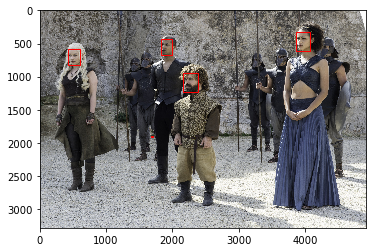

In [33]:
highlight_faces('iacocca_1.jpg', faces)

In [34]:
image = plt.imread('iacocca_2.jpg')
faces = detector.detect_faces(image)


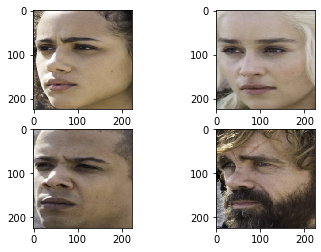

In [42]:
from numpy import asarray
from PIL import Image

def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height

        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_images.append(face_array)

    return face_images

Mereen_faces = extract_face_from_image('iacocca_1.jpg')

# Display the first face from the extracted faces
plt.subplot(221)
plt.imshow(Mereen_faces[0])

plt.subplot(222)
plt.imshow(Mereen_faces[1])

plt.subplot(223)
plt.imshow(Mereen_faces[2])

plt.subplot(224)
plt.imshow(Mereen_faces[3])


# Explainable AI 1 - Describing saliency maps on faces to show their face recognitions
# Explainable AI 2 - Visualize K-means clustering to show justification for classification of unknown faces
